<a href="https://colab.research.google.com/github/Nisha40108/ParkNaviGo/blob/main/CNN_model_for_occupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### 1. Load Test and Train Files

In [6]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = '/content/drive/MyDrive/nisha/train_data/train'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)


folder = '/content/drive/MyDrive/nisha/train_data/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

381 164


### 2. Set key parameters

In [7]:
img_width, img_height = 48, 48
train_data_dir = "/content/drive/MyDrive/nisha/train_data/train"
validation_data_dir = "/content/drive/MyDrive/nisha/train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [8]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
x = model.output
x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

from keras.models import Model
# creating the final model
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy",
                    optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                    metrics=["accuracy"]) # See learning rate is very low

In [13]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [18]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')


In [19]:
history_object = model_final.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,  # Adjust as needed
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,  # Adjust as needed
    callbacks=[checkpoint, early]
)


Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9599
Epoch 1: val_accuracy improved from -inf to 0.91875, saving model to car1.h5
11/11 [==============================] - 35s 3s/step - loss: 0.1709 - accuracy: 0.9599 - val_loss: 0.2095 - val_accuracy: 0.9187


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9685
Epoch 2: val_accuracy improved from 0.91875 to 0.93125, saving model to car1.h5
11/11 [==============================] - 34s 3s/step - loss: 0.1257 - accuracy: 0.9685 - val_loss: 0.1531 - val_accuracy: 0.9312
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.9771
Epoch 3: val_accuracy did not improve from 0.93125
11/11 [==============================] - 34s 3s/step - loss: 0.0980 - accuracy: 0.9771 - val_loss: 0.1799 - val_accuracy: 0.9250
Epoch 4/15
11/11 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9659
Epoch 4: val_accuracy did not improve from 0.93125
11/11 [==============================] - 31s 3s/step - loss: 0.0964 - accuracy: 0.9659 - val_loss: 0.1597 - val_accuracy: 0.9187
Epoch 5/15
11/11 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9828
Epoch 5: val_accuracy did not improve from 0.93125
11/1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


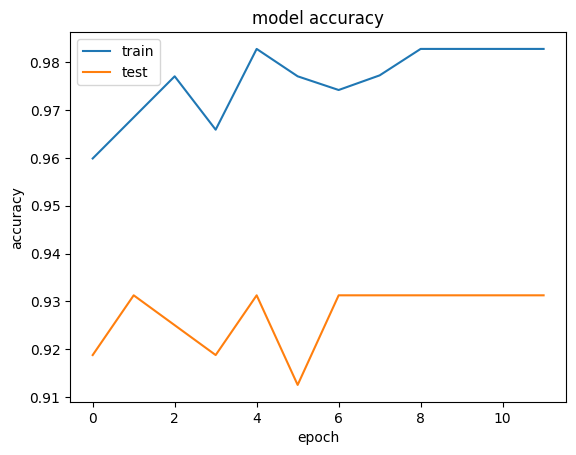

In [23]:
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['accuracy'])
plt.plot(history_object.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

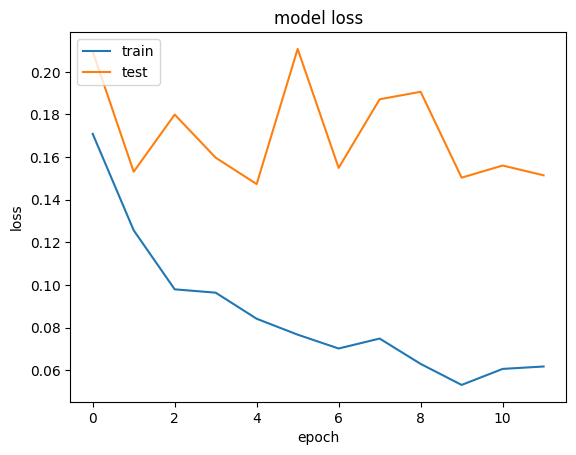

In [24]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()